In [1]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 28.6 MB/s 
     |████████████████████████████████| 596 kB 60.4 MB/s 
     |████████████████████████████████| 101 kB 13.8 MB/s 
     |████████████████████████████████| 6.6 MB 58.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip3 install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 30.9 MB/s 


In [3]:
!pip3 install Tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing the libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.nn import Dropout
import torch.nn.functional as F
from torchtext.data import get_tokenizer
from torch.utils.data.dataset import random_split
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torchmetrics import F1Score
from torch.utils.tensorboard import SummaryWriter

## Loading the data

In [5]:
df = pd.read_csv('quora_duplicate_questions.tsv', sep = '\t')

## Removing Null records

In [6]:
df = df.dropna(how='any',axis=0) 

## Finding the token frequency

In [7]:

#que_df = df[["question1"]]
que_df = pd.concat((df['question1'], df['question2']),axis =0,ignore_index=True)
#que_df["question1"] = df[["question2"]]
que_df.columns = ['Questions']

In [8]:
que_df

0         What is the step by step guide to invest in sh...
1         What is the story of Kohinoor (Koh-i-Noor) Dia...
2         How can I increase the speed of my internet co...
3         Why am I mentally very lonely? How can I solve...
4         Which one dissolve in water quikly sugar, salt...
                                ...                        
627641                            Why do people need sleep?
627642    What's the difference between a product manage...
627643    What would be the difference(s) in structuring...
627644    What are the most eagerly awaited Hollywood mo...
627645              How do I unlock a lock without the key?
Length: 627646, dtype: object

In [9]:
num_words = que_df.apply(lambda row: len(row.split(" ")))



AxesSubplot(0.125,0.125;0.775x0.755)


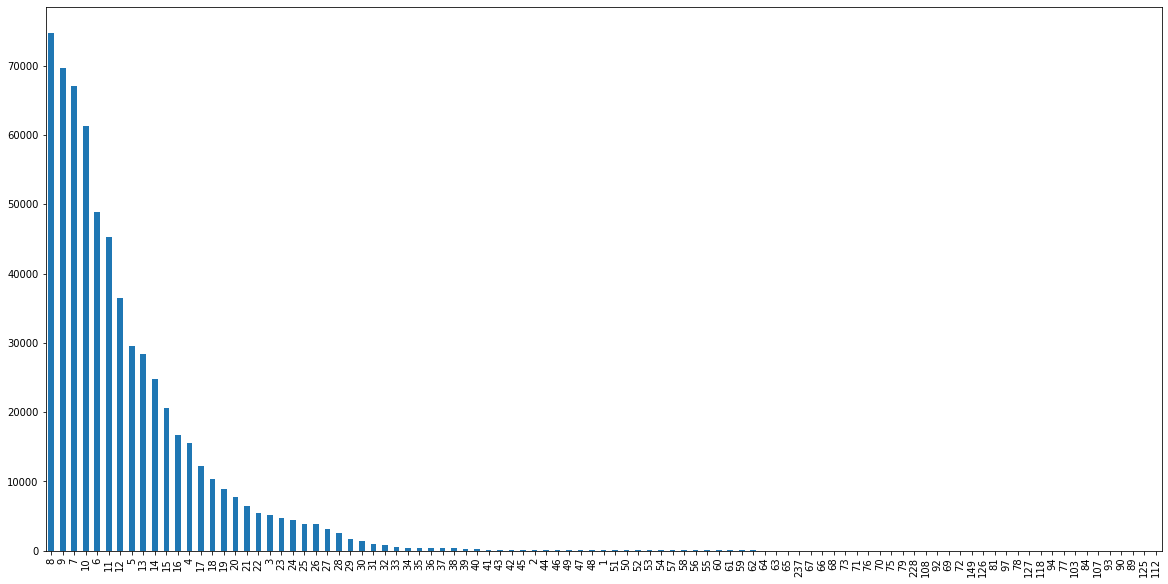

In [10]:
print(num_words.value_counts().plot(kind="bar", figsize = (20,10)))

## Preprocessing the data

In [11]:
class Preprocessing:
	
    def __init__(self):
		    self.data = 'quora_duplicate_questions.tsv'
		    self.max_len = 60
		    self.max_words = 6000
		    self.test_size = 0.2
		    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
		
    def load_data(self):
		    df = pd.read_csv(self.data, sep ='\t')
		    df.drop(['id','qid1','qid2'], axis=1, inplace=True)
		    df = df.dropna()
		    X = df[['question1','question2']]
		    Y = df['is_duplicate']
		    #print(df)
		    #lens = [int(len(df)*0.8), int(len(df)*0.2)]
		    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X,Y, random_state = 123, test_size=0.2)

    def sequence_to_token(self):
		    #print(list(self.X_train['question1']))
		    question_1_train = self.tokenizer(list(self.X_train['question1']), padding='max_length', truncation=True, max_length=self.max_len)
		    question_2_train = self.tokenizer(list(self.X_train['question2']), padding='max_length', truncation=True, max_length= self.max_len)
		    question_1_test = self.tokenizer(list(self.X_test['question1']), padding='max_length', truncation=True, max_length=self.max_len)
		    question_2_test = self.tokenizer(list(self.X_test['question2']), padding='max_length', truncation=True, max_length= self.max_len)
		    return question_1_train['input_ids'] , question_2_train['input_ids'], question_1_test['input_ids'] , question_2_test['input_ids']

In [12]:
pro = Preprocessing()

In [13]:
pro.load_data()

In [14]:
pro.X_train

,question1,question2
229518,What can I do when I miss my home?,Why do I miss my home?
9499,How do I maintain my weight loss after a GM diet?,Is the GM Diet Plan an effective and advised d...
101201,What is the chemical formula for fermentation?,What is the chemical formula for ethanol?
27895,Can World War 3 ever take place?,How likely is World War III in the future?
308949,What is the most disgusting thing that happene...,What's the most disgusting thing one can do?
...,...,...
192477,What happens if a lightning strikes in the ocean?,What happens when lightning strikes the oceans...
17730,How can dogs understand human language?,Can dogs understand the human language?
28030,What's your favourite lotion?,What's your favourite skin lotion?
277871,How is SRCC's GBO programme?,"Which of these college is better for MBA, SRCC..."


In [15]:
question_1_train, question_2_train, question_1_test, question_2_test = pro.sequence_to_token()

## Defining the model

In [16]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.10)
    
    def forward(self,x):
        h_0 = Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.dropout(hn)
        out = self.relu(out)
        out = self.fc_1(out) #first Dense
        out = self.dropout(out)
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        out = self.sigmoid(out)
        return out
 

In [31]:
num_epochs = 50 #50 epochs
learning_rate = 0.01 #0.001 lr

input_size = 120 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [32]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers,120) #our lstm class
       

In [19]:
pro.y_train

229518    0.0
9499      0.0
101201    0.0
27895     1.0
308949    0.0
         ... 
192477    1.0
17730     0.0
28030     1.0
277871    0.0
249344    0.0
Name: is_duplicate, Length: 268494, dtype: float64

In [20]:
Question1_train_tensors = Variable(torch.Tensor(question_1_train))
Question1_test_tensors = Variable(torch.Tensor(question_1_test))
Question2_train_tensors = Variable(torch.Tensor(question_2_train))
Question2_test_tensors = Variable(torch.Tensor(question_2_test))

y_train_tensors = Variable(torch.Tensor(pro.y_train.values))
y_test_tensors = Variable(torch.Tensor(pro.y_test.values)) 

In [21]:
Question1_train_final = torch.reshape(Question1_train_tensors,   (Question1_train_tensors.shape[0], 1, Question1_train_tensors.shape[1]))
Question2_train_final = torch.reshape(Question2_train_tensors,   (Question2_train_tensors.shape[0], 1, Question2_train_tensors.shape[1]))
Question1_test_final = torch.reshape(Question1_test_tensors,  (Question1_test_tensors.shape[0], 1, Question1_test_tensors.shape[1])) 
Question2_test_final = torch.reshape(Question2_test_tensors,  (Question2_test_tensors.shape[0], 1, Question2_test_tensors.shape[1])) 

In [33]:
criterion = nn.BCELoss()    # Binary classification loss
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [23]:
Question1_train_final.size()

torch.Size([268494, 1, 60])

In [24]:
Question2_train_final.size()

torch.Size([268494, 1, 60])

## Concatenate the tensors

In [25]:
X_train_tensors = torch.cat((Question1_train_final,Question2_train_final),2)

In [26]:
X_test_tensors = torch.cat((Question1_test_final,Question2_test_final),2)

In [27]:
X_train_tensors

tensor([[[ 101., 2054., 2064.,  ...,    0.,    0.,    0.]],

        [[ 101., 2129., 2079.,  ...,    0.,    0.,    0.]],

        [[ 101., 2054., 2003.,  ...,    0.,    0.,    0.]],

        ...,

        [[ 101., 2054., 1005.,  ...,    0.,    0.,    0.]],

        [[ 101., 2129., 2003.,  ...,    0.,    0.,    0.]],

        [[ 101., 2054., 2003.,  ...,    0.,    0.,    0.]]])

In [28]:
X_train_tensors.size()

torch.Size([268494, 1, 120])

## Training the model and evaluating the accuracy

In [34]:
threshold = torch.tensor([0.5])
losses = []
acc = 0
accu = []
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  #threshold = torch.tensor([0.5]) # setting threshold

  # results = (outputs>threshold).float()*1

  # obtain the loss function
  loss = criterion(torch.squeeze(outputs), y_train_tensors)
  #print(loss)

  
  results = (outputs>threshold).float()*1
  f1 = F1Score(num_classes=2) 
  acc = f1(torch.squeeze(results).type(torch.int), y_train_tensors.type(torch.int))

  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 10 == 0:
    losses.append(loss)
    accu.append(acc)
    print("epoch {}\tloss : {}\t accuracy : {}".format(epoch,loss,acc))



epoch 0	loss : 0.6966380476951599	 accuracy : 0.46482229232788086
epoch 10	loss : 0.6259762644767761	 accuracy : 0.6289302706718445
epoch 20	loss : 0.6203933358192444	 accuracy : 0.6399286389350891
epoch 30	loss : 0.6168137192726135	 accuracy : 0.645891547203064
epoch 40	loss : 0.6147298812866211	 accuracy : 0.6494521498680115


##Test Accuracy

In [39]:
output_test = lstm1(X_test_tensors)
loss_test = criterion(torch.squeeze(output_test), y_test_tensors)
results_test = (output_test>torch.tensor([0.5])).float()*1


In [40]:
f1 = F1Score(num_classes=2) 
acc = f1(torch.squeeze(results_test).type(torch.int), y_test_tensors.type(torch.int))

In [41]:
acc

tensor(0.6516)